# Probablistic Model

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split

import keras.backend as K

In [121]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y==0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)

def multivariate_gaussian_nll(ypreds, ytrue, var):
    """Keras implmementation of multivariate Gaussian negative loglikelihood loss function. 
    This implementation implies diagonal covariance matrix.
    
    Parameters
    ----------
    ytrue: tf.tensor of shape [n_samples, n_dims]
        ground truth values
    ypreds: tf.tensor of shape [n_samples, n_dims*2]
        predicted mu and logsigma values (e.g. by your neural network)
        
    Returns
    -------
    neg_log_likelihood: float
        negative loglikelihood averaged over samples
        
    This loss can then be used as a target loss for any keras model, e.g.:
        model.compile(loss=gaussian_nll, optimizer='Adam') 
    
    """
    #print(f"ytrue: {ytrue.shape}")
    #print(f"ypreds: {ypreds.shape}")
    
    diag = torch.exp(2*var[:,:2])
    n = ypreds.shape[1]
    B = ypreds.shape[0]
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2)
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2)
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2)

    sigma = L @ D @ LT
    ximu =(ytrue-ypreds).reshape(B,1,2)
    ximuT =(ytrue-ypreds).reshape(B,2,1)
    # print(ximuT.shape)
    # print(ximu.shape)
    # print(sigma.shape)
    loss = 0.5*torch.sum(ximu@sigma@ximuT + ((n/2)*(-1*torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss

#### Load Data

In [122]:
data = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

In [123]:
print(data[0])

[6.200e+02 2.880e-06 3.775e+00 8.280e+10]


##### Split data into inputs X and target Y Normalize to [0,1] (inclusive) and create Training and Testign Splits


In [124]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data)
X = data[:,:2]
Y = data[:,2:]

#### Define Model and Parameters

##### Define model

* Model: MLP with variable hidden layer number and width  
* Output layer: 
    * Node 1 and 2 are the mean for probability mean 
    * Node 3 and 4 are the diagonal of the covariance matrix


In [125]:
# num_hidden_layers = 5
# hidden_layer_size = 500

# model = tf.keras.models.Sequential([])

# for i in range(num_hidden_layers):
#     model.add(tf.keras.layers.Dense(hidden_layer_size, activation='relu'))
# model.add(tf.keras.layers.Dense(4, activation='sigmoid')) # add output layer: node 1,2 are 

In [129]:
test_model = model.DistModel50x10(2,5)

##### Define Loss

* Loss: guassian_nll
    * cite: https://gist.github.com/sergeyprokudin/4a50bf9b75e0559c1fcd2cae860b879e

In [130]:
optimizer = optim.Adam(test_model.parameters(),lr=0.001)
loss_fn = multivariate_gaussian_nll

dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.95)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [131]:
epochs = 250
loss_list, val_loss_list = train.trainProbModel(test_model, train_data, loss_fn, optimizer, num_epochs=epochs, print_every=10, validation_data=validation_data)

t = 10, loss = -12332.4678, val loss = -6461.2451
t = 20, loss = -14135.7525, val loss = -7147.7368
t = 30, loss = -40992.5905, val loss = -24330.5977
t = 40, loss = -67596.9798, val loss = -40321.4258
t = 50, loss = -173949.4180, val loss = -103137.9141
t = 60, loss = -181734.0117, val loss = -106291.6797
t = 70, loss = -185483.0026, val loss = -108485.0781
t = 80, loss = -186262.5091, val loss = -108769.5703
t = 90, loss = -186942.9115, val loss = -108678.9219
t = 100, loss = -186555.3529, val loss = -107976.9922
t = 110, loss = -186669.1354, val loss = -108617.5312
t = 120, loss = -187675.8542, val loss = -109520.9375
t = 130, loss = -187328.6458, val loss = -109537.6562
t = 140, loss = -188451.3763, val loss = -110078.9766
t = 150, loss = -188816.1536, val loss = -110319.9375
t = 160, loss = -189761.2005, val loss = -110837.5781
t = 170, loss = -191240.2266, val loss = -112077.6562
t = 180, loss = -194810.3385, val loss = -116973.2656
t = 190, loss = -190399.6068, val loss = -12040

## Loss visualization

Loss plots for training and validation by epoch

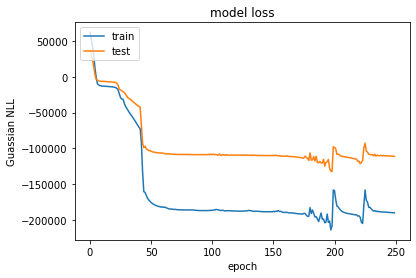

In [132]:
plt.plot(np.arange(len(loss_list)),loss_list)
plt.plot(np.arange(len(val_loss_list)),val_loss_list)
plt.title('model loss')
plt.ylabel('Guassian NLL')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing scipt

My idea of the testing script. 
It takes the inverse simulator prediction (Y -> X^)  
Pass X^ to mock_simulator to get Y^   
evaluate performance from Y to Y^  
I don't know if the data is being shuffled at all could contribute too the poor performance

In [118]:
x_preds = test_model(torch.Tensor(Y))
#print(x_preds)
mock_simulator = tf.keras.models.load_model('mock_simulator')

final_preds = []
for i in range(x_preds.shape[0]):
    means = x_preds.detach().numpy()[i,:2].T
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_preds.append(y_hat)
final_preds = np.array(final_preds).reshape(-1,2)
    

# for i,d in enumerate(final_preds):
#     print(Y[i],d)
print(final_preds)


[[0.5153474  0.69657034]
 [0.5157631  0.6958994 ]
 [0.521984   0.68585736]
 ...
 [0.9059506  0.13781458]
 [0.91851705 0.12395515]
 [0.93198574 0.11002131]]


In [119]:
check_acc(Y,final_preds,margin=.05)

Correct = 11 / 3022


0.003639973527465255

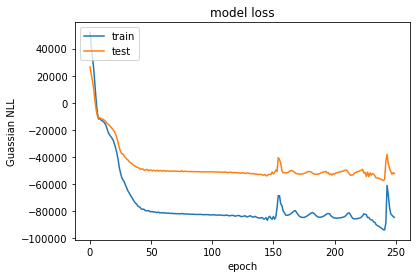

In [120]:
plt.plot(np.arange(len(loss_list)),loss_list)
plt.plot(np.arange(len(val_loss_list)),val_loss_list)
plt.title('model loss')
plt.ylabel('Guassian NLL')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# loss_fn = gaussian_nll

# optim = tf.keras.optimizers.Adam(
#     learning_rate=0.001)
# model.compile(optimizer=optim,
#               loss=loss_fn)

In [15]:
# model.fit(X_train, y_train, epochs=1000, batch_size= 700, validation_data=(X_test, y_test))

In [16]:
 #mse = -0.5*K.sum(K.square((ytrue-mu)/K.exp(logsigma)),axis=1)
    #sigma_trace = -K.sum(logsigma, axis=1)
    #log2pi = -0.5*n_dims*np.log(2*np.pi)
    
    
    #log_likelihood = 0.5 * K.log(sigma**2) + (ytrue-mu)**2 / (sigma)

In [17]:
np.arange(4).reshape(2,2)

array([[0, 1],
       [2, 3]])

In [18]:
a = np.arange(12).reshape(3,2,2)

In [19]:
b = np.arange(12).reshape(3,2,2)

In [20]:
a[0] @ b[0]

array([[ 2,  3],
       [ 6, 11]])

In [21]:
a

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]]])

In [22]:
a * np.eye(6,2,2)

ValueError: operands could not be broadcast together with shapes (3,2,2) (6,2) 

In [ ]:
a[0].T @ np.eye(2)

In [ ]:
d = np.array([2,3])

In [ ]:
d

In [ ]:
d.T @ np.eye(2)

In [ ]:
i = np.ones(2)
z = np.zeros((2,2))
np.einsum('i,jk->jj', i,z)

In [ ]:
a = np.arange(4*3).reshape(4,3)

In [ ]:
print(a)
np.zeros()
x = np.array([[1,2],[3,4]])
np.repeat(a,[1,2,1], axis = 1).reshape(4,2,2)

In [ ]:
a = np.arange(2*3).reshape(3,2)
a[:,0].reshape(3,1)

In [ ]:
b = np.zeros((3,1))
b

In [ ]:
d = np.hstack((a[:,0].reshape(3,1),b,b,a[:,1].reshape(3,1)))
print(d)
D = d.reshape(3,2,2)

In [ ]:
l = np.arange(3).reshape(3,1)
l

In [ ]:
o = np.ones((3,1))
z = np.zeros((3,1))

L = np.hstack((o,z,l,o))
L = L.reshape(3,2,2)
LT = np.hstack((o,l,z,o))
LT =LT.reshape(3,2,2)

In [ ]:
print(L.shape,D.shape,LT.shape)
L@D@LT

In [ ]:
LT,L